In [1]:
import os
import sys
import gc
import pickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)
warnings.simplefilter('ignore')
sns.set()

In [2]:
base_dir = Path().resolve()
sys.path.append(str(base_dir / '../'))

from utils.preprocess import *
from utils.model import *
from utils.train import *
from utils.eval import *

fail to import apex_C: apex was not installed or installed without --cpp_ext.
fail to import amp_C: apex was not installed or installed without --cpp_ext.


In [3]:
def seed_everything(seed: int, device: str):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    with torch.cuda.device(device):
        torch.cuda.empty_cache()

In [4]:
from dataclasses import dataclass, field, asdict
import yaml


@dataclass
class Config:
    # General
    debug: bool = False
    outdir: str = "results00"
    device: str = "cuda:0"

    # Data config
    imgconf_file: str = '../../data/VinBigData/train.csv'
    imgdir_name: str = "../../data/VinBigData/png256"
    img_size: int = 256
    seed: int = 111
    n_splits: int = 5
    
    # Training config
    batch_size: int = 8
    patience: int = 10
    epochs: int = 20
    train_aug_kwargs: Dict[str, Dict[str, Any]] = field(default_factory=lambda: {})
    valid_aug_kwargs: Dict[str, Dict[str, Any]] = field(default_factory=lambda: {})
    test_aug_kwargs: Dict[str, Dict[str, Any]] = field(default_factory=lambda: {})

    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [5]:
config_dict = {
    'debug': False,
    'batch_size': 25,
    'patience': 5,
    'epochs': 15,
    "train_aug_kwargs": {
#         "HorizontalFlip": {"p": 0.5},
        "Normalize": {"mean": (0, 0, 0), "std": (1, 1, 1), "max_pixel_value": 255.}
    },
    "valid_aug_kwargs": {
        "Normalize": {"mean": (0, 0, 0), "std": (1, 1, 1), "max_pixel_value": 255.}
    },
    "test_aug_kwargs": {
        "Normalize": {"mean": (0, 0, 0), "std": (1, 1, 1), "max_pixel_value": 255.}
    },
}
config = Config().update(config_dict)
config.to_yaml(base_dir / config.outdir / 'config.yaml')

In [6]:
classes_nms = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]
classes_dict = {index: class_name  for index, class_name in enumerate(classes_nms)}

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


def load_faster_rcnn():
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = len(classes_dict) + 1  # 14 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [35]:
from torch.utils.data.dataset import Dataset

class VinBigDataset(Dataset):
    def __init__(self, dataset_dicts: Dict[str, Any], transform: Transform, train: bool = True):
        self.train = train
        if self.train:
            assert not len([dd for dd in dataset_dicts if len(dd['annotations']) > 0]) == 0
        self.dataset_dicts = dataset_dicts
        self.transform = transform
        
        self.image_ids, counts = np.unique([dd['image_id'] for dd in self.dataset_dicts], return_counts=True)
        self.image_ids = self.image_ids.tolist()
        assert np.all(counts == 1)
    
    def __len__(self) -> int:
        return len(self.dataset_dicts)
    
    def __getitem__(self, index: int):
        img = cv2.imread(self.dataset_dicts[index]['file_name'])
        img = self.transform(img)
        img = torch.tensor(np.transpose(img, (2, 0, 1)).astype(np.float32))
        
        if self.train:
            target = {}
            target['boxes'] = torch.tensor(np.vstack([ant['bbox'] for ant in self.dataset_dicts[index]['annotations']]), dtype=torch.float32)
            target['labels'] = torch.tensor([ant['category_id'] for ant in self.dataset_dicts[index]['annotations']], dtype=torch.int64)
            target['image_id'] = torch.tensor([index])
            target['area'] = torch.tensor((target['boxes'][:, 3] - target['boxes'][:, 1]) * (target['boxes'][:, 2] - target['boxes'][:, 0]), dtype=torch.float32)
            target['iscrowd'] = torch.zeros((len(self.dataset_dicts[index]['annotations']), ), dtype=torch.int64)

            return img, target, self.dataset_dicts[index]['image_id']
        else:
            return img, self.dataset_dicts[index]['image_id']

In [9]:
def load_train_data(filepath: str, meta_filepath: str, img_size: int) -> pd.DataFrame:
    train = pd.read_csv(filepath)
    train.fillna(0, inplace=True)
    train.loc[train["class_id"] == 14, ['x_max', 'y_max']] = 1.0
    
    train_meta = pd.read_csv(meta_filepath)
    
    train = pd.merge(train, train_meta, how='left', on='image_id')
    
    train[f'x_min_{img_size}'] = (img_size / train['dim1'] * train['x_min']).astype(int)
    train[f'x_max_{img_size}'] = (img_size / train['dim1'] * train['x_max']).astype(int)
    train[f'y_min_{img_size}'] = (img_size / train['dim0'] * train['y_min']).astype(int)
    train[f'y_max_{img_size}'] = (img_size / train['dim0'] * train['y_max']).astype(int)
    
    return train

In [10]:
# !pip install pip install iterative-stratification
# # https://pypi.org/project/iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


class MultilabelKFoldWrapper:
    NOFINDING = 14
    
    def __init__(self, train: pd.DataFrame, n_splits: int, seed: int):
        if self.NOFINDING in train['class_id'].unique():
            self.train = train.query(f'class_id != {self.NOFINDING}').reset_index(drop=True)
            print(f'Removing class_id = {self.NOFINDING}: {train.shape[0]} → {self.train.shape[0]}')
        else:
            self.train = train
        self.classes = [f'class_{i}' for i in range(14)]

        self.n_splits = n_splits
        self.seed = seed
        
        self.annot_pivot = None
        self.stats = None
        
        self.__i = -1
        self.__split()
    
    def __iter__(self):
        self.__i = -1
        return self
    
    def __next__(self):
        self.__i += 1
        if self.__i < 0 or self.n_splits <= self.__i:
            raise StopIteration()
        return self.__getitem__(idx=self.__i)
    
    def __len__(self) -> int:
        return self.n_splits
    
    def __getitem__(self, idx: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
        if idx < 0 or self.n_splits <= idx:
            raise ValueError()
        return self.train.query(f'fold != {idx}').reset_index(drop=True), self.train.query(f'fold == {idx}').reset_index(drop=True)
    
    def __split(self) -> None:
        kf = MultilabelStratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)
        self.train['id'] = self.train.index
        annot_pivot = pd.pivot_table(self.train, index='image_id', columns='class_id', values='id', fill_value=0, aggfunc='count').reset_index().rename_axis(None, axis=1)
        annot_pivot = annot_pivot.rename(columns={i: cls_nm for i, cls_nm in enumerate(self.classes)})

        annot_pivot['fold'] = -1
        for fold, (train_idx, valid_idx) in enumerate(kf.split(annot_pivot, annot_pivot.loc[:, self.classes])):
            annot_pivot.loc[valid_idx, 'fold'] = fold
        
        self.annot_pivot = annot_pivot
        self.stats = self.annot_pivot.groupby('fold').sum().reset_index()
        
        self.train = pd.merge(self.train, self.annot_pivot, how='left', on='image_id').drop(columns=['id'] + self.classes)
    
    def plot_stats(self) -> None:
        fig, axes = plt.subplots(1, 5, figsize=(25, 6))
        cols = self.stats.columns[1:-1]
        for fold, ax in enumerate(axes):
            ax.bar(cols, self.stats.loc[fold, cols], tick_label=cols)
            ax.set_title(f'fold = {fold}')
        plt.show()

In [11]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [12]:
from functools import reduce
from operator import add
from copy import deepcopy


class ObjectDetector(pl.LightningModule):
    def __init__(self, model: torch.nn.Module, train_evaluator: VinBigDataEval, valid_evaluator: VinBigDataEval):
        super().__init__()
        self.model = model
        
        self.history = {c: list() for c in ['train_loss', 'valid_loss', 'valid_mAP@.4', 'valid_mAP@.4_s', 'valid_mAP@.4_m', 'valid_mAP@.4_l']}
        
        self.train_evaluator = train_evaluator
        self.valid_evaluator = valid_evaluator
            
    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        # in lightning, forward defines the prediction/inference actions
        return self.model(x)
    
    def training_step(self, train_batch, batch_idx):        
        images, targets, _ = train_batch
        images, targets = self.__to_gpu(images, targets)
        
        loss_dict = self.model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        self.log('train_loss', loss_value, prog_bar=True)
        
        return {'loss': losses}
    
    def training_epoch_end(self, outputs: List[Dict[str, Any]]):
        self.__logging(metric='train_loss', value=np.mean([float(op['loss']) for op in outputs]))
    
    def validation_step(self, valid_batch, batch_idx):        
        images, targets, image_ids = valid_batch
        images, targets = self.__to_gpu(images, targets)
        
        with torch.no_grad():
            self.model.train()
            loss_dict = self.model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            
            self.model.eval()
            preds = self.model(images)
        
        self.log('valid_loss', loss_value, prog_bar=True)
        
        return {'loss': loss_value, 'preds': preds, 'image_ids': image_ids}
    
    def validation_epoch_end(self, outputs: List[Dict[str, Any]]):
        preds = reduce(add, [op['preds'] for op in outputs])
        image_ids = reduce(add, [op['image_ids'] for op in outputs])
        
        pred_df = self.to_predict_string(preds=preds, image_ids=image_ids)
        
#         assert not np.any(pred_df['PredictionString'].apply(lambda x: len(x)) == 0)
        results = self.valid_evaluator.evaluate(pred_df)
        
        self.__logging(metric='valid_loss', value=np.mean([float(op['loss']) for op in outputs]))
        self.__logging(metric='valid_mAP@.4', value=results.stats[0])
        self.__logging(metric='valid_mAP@.4_s', value=results.stats[3], prog_bar=False)
        self.__logging(metric='valid_mAP@.4_m', value=results.stats[4], prog_bar=False)
        self.__logging(metric='valid_mAP@.4_l', value=results.stats[5], prog_bar=False)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def to_dataframe(self) -> pd.DataFrame:
        records = self.history.copy()
        
        min_len = min([len(metric) for metric in self.history.keys()])
        for metric in records.keys():
            records[metric] = records[metric][-min_len:]
            
        return pd.DataFrame(records)
    
    def to_predict_string(self, preds: List[Dict[str, torch.Tensor]], image_ids: List[str]) -> pd.DataFrame:    
        assert len(preds) == len(image_ids)
        
        records = {'image_id': list(), 'PredictionString': list()}

        for pred, image_id in zip(preds, image_ids):
            boxes = pred['boxes'].detach().cpu().numpy()
            labels = pred['labels'].detach().cpu().numpy()
            scores = pred['scores'].detach().cpu().numpy()

            pred_list = []
            for box, label, score in zip(boxes, labels, scores):
                pred_list += [str(label)] + [str(score)] + box.astype(int).astype(str).tolist()

            records['image_id'] += [image_id]
            records['PredictionString'] += [' '.join(pred_list)]
        return pd.DataFrame(records)
    
    def __to_gpu(self, images, targets) -> Tuple[torch.tensor, torch.tensor]:
        images = list(image.to(self.device) for image in images)
        targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
        
        return images, targets
        
    def __logging(self, metric: str, value: float, prog_bar: bool = True):
        self.log(metric, value, prog_bar=prog_bar)
        
        assert metric in self.history.keys()
        self.history[metric] += [value]

In [13]:
train = load_train_data(filepath=str(base_dir / config.imgconf_file), meta_filepath=str(base_dir / config.imgdir_name / 'train_meta.csv'), img_size=config.img_size)
mkf = MultilabelKFoldWrapper(train, config.n_splits, config.seed)

Removing class_id = 14: 67914 → 36096


In [14]:
dataset_dicts = get_vinbigdata_dicts(
    imgdir=base_dir / config.imgdir_name, 
    train_df=train, 
    debug=config.debug,
)

Load from cache dataset_dicts_cache_original_debug0.pkl


In [15]:
fold = 0

train_idx = list(pd.DataFrame({'image_id': [dd['image_id'] for dd in dataset_dicts]}).query(f"image_id in {mkf[fold][0]['image_id'].values.tolist()}").index)
valid_idx = list(pd.DataFrame({'image_id': [dd['image_id'] for dd in dataset_dicts]}).query(f"image_id in {mkf[fold][1]['image_id'].values.tolist()}").index)

In [39]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [16]:
train_dataset = VinBigDataset(dataset_dicts=[dataset_dicts[i] for i in train_idx], transform=Transform(config.train_aug_kwargs))
valid_dataset = VinBigDataset(dataset_dicts=[dataset_dicts[i] for i in valid_idx], transform=Transform(config.valid_aug_kwargs))

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)


cols = ['x_min', 'y_min', 'x_max', 'y_max']
train_ = train.drop(columns=['x_min', 'y_min', 'x_max', 'y_max']).rename(columns={f'{c}_{config.img_size}': c for c in cols})

train_evaluator = VinBigDataEval(train_.query(f'image_id in {train_dataset.image_ids}'))
valid_evaluator = VinBigDataEval(train_.query(f'image_id in {valid_dataset.image_ids}'))

Generating image data...
Generating category data...
Generating annotation data...
Generating image data...
Generating category data...
Generating annotation data...


In [17]:
early_stop_callback = EarlyStopping(monitor='valid_mAP@.4', min_delta=0.00, patience=config.patience, verbose=True, mode='max')
trainer = pl.Trainer(gpus=1, max_epochs=config.epochs, weights_summary='full', callbacks=[early_stop_callback])

detector = ObjectDetector(model=load_faster_rcnn(), train_evaluator=train_evaluator, valid_evaluator=valid_evaluator)
trainer.fit(detector, train_loader, valid_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

    | Name                                      | Type                     | Params
-----------------------------------------------------------------------------------------
0   | model                                     | FasterRCNN               | 41.4 M
1   | model.transform                           | GeneralizedRCNNTransform | 0     
2   | model.backbone                            | BackboneWithFPN          | 26.8 M
3   | model.backbone.body                       | IntermediateLayerGetter  | 23.5 M
4   | model.backbone.body.conv1                 | Conv2d                   | 9.4 K 
5   | model.backbone.body.bn1                   | FrozenBatchNorm2d        | 0     
6   | model.backbone.body.relu                  | ReLU                     | 0     
7   | model.backbone.body.maxpool               | MaxPool2d                | 0     
8   | model.backbone.body.layer1                | Sequential               | 212 

Validation sanity check: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.69s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.004
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.73s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.005
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.99s).
Accumulating evaluation results...
DONE (t=0.18s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.078
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.037
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.098
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.100
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.58s).
Accumulating evaluation results...
DONE (t=0.31s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.240
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.321
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.088
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.278
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.303
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.95s).
Accumulating evaluation results...
DONE (t=0.17s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.060
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.143
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.071
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.145
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.146
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.37s).
Accumulating evaluation results...
DONE (t=0.26s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.107
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.275
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.287
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.17s).
Accumulating evaluation results...
DONE (t=0.25s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.332
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.121
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.285
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.21s).
Accumulating evaluation results...
DONE (t=0.40s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.360
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.167
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.372
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.378
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.93s).
Accumulating evaluation results...
DONE (t=0.38s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.413
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.212
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.520
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.91s).
Accumulating evaluation results...
DONE (t=0.38s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.437
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.244
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.590
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.607
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.69s).
Accumulating evaluation results...
DONE (t=0.31s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.440
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.238
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.541
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.560
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.89s).
Accumulating evaluation results...
DONE (t=0.37s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.508
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.237
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.573
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.599
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.91s).
Accumulating evaluation results...
DONE (t=0.57s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.419
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.276
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.641
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.657
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.84s).
Accumulating evaluation results...
DONE (t=0.36s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.465
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.258
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.623
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.646
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.67s).
Accumulating evaluation results...
DONE (t=0.33s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.529
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.263
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.590
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.607
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.74s).
Accumulating evaluation results...
DONE (t=0.32s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.239
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.537
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.266
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.602
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.621
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

1

In [18]:
detector.to_dataframe().to_csv(str(base_dir / config.outdir / 'history.csv'))
torch.save(detector.state_dict(), str(base_dir / config.outdir / 'model_last.pt'))

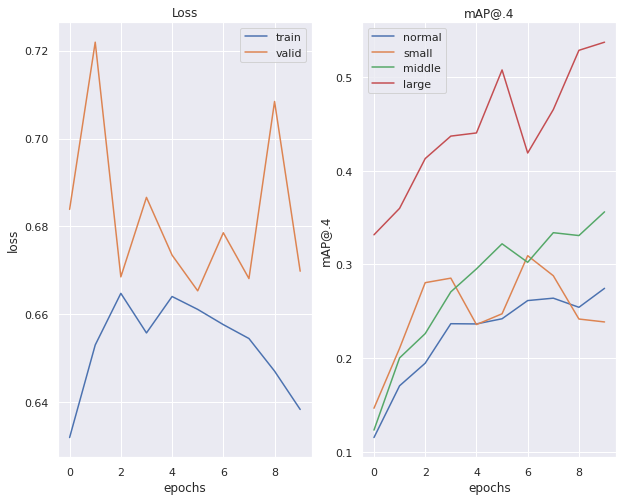

In [26]:
history = pd.read_csv(base_dir / config.outdir / 'history.csv', index_col=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 8))
axes[0].plot(history['train_loss'], label='train')
axes[0].plot(history['valid_loss'], label='valid')
axes[0].set_title('Loss')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('loss')
axes[0].legend()

axes[1].plot(history['valid_mAP@.4'], label='normal')
axes[1].plot(history['valid_mAP@.4_s'], label='small')
axes[1].plot(history['valid_mAP@.4_m'], label='middle')
axes[1].plot(history['valid_mAP@.4_l'], label='large')
axes[1].set_title('mAP@.4')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('mAP@.4')
axes[1].legend()
plt.show()

In [18]:
# device = torch.device(config.device)
# detector.to(device)

# for batch in valid_loader:
#     images, targets, _ = batch
#     images = list(image.to(device) for image in images)
#     targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#     detector.eval()
#     preds = detector.model(images)
#     break

### Prediction

In [36]:
test_meta = pd.read_csv(str(base_dir / config.imgdir_name / 'test_meta.csv'))
dataset_dicts_test = get_vinbigdata_dicts_test(base_dir / config.imgdir_name, test_meta, debug=config.debug)

Load from cache dataset_dicts_cache_test_debug0.pkl


In [40]:
test_dataset = VinBigDataset(dataset_dicts=dataset_dicts_test, transform=Transform(config.test_aug_kwargs), train=False)
test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [110]:
device = torch.device(config.device)

detector = ObjectDetector(model=load_faster_rcnn(), train_evaluator=None, valid_evaluator=None)
detector.load_state_dict(torch.load(str(base_dir / config.outdir / 'model_last.pt')))
detector.to(device)
detector.eval()

preds_list = list()
for batch in tqdm(test_loader):
    images, image_ids = batch
    images = list(image.to(device) for image in images)
    preds = detector(images)
    
    del images
    gc.collect()
    
    for i in range(len(preds)):
        preds[i] = {k: preds[i][k].detach().cpu().numpy() for k in preds[i].keys()}
        preds[i]['image_id'] = image_ids[i]
    preds_list += preds

  0%|          | 0/120 [00:00<?, ?it/s]

In [112]:
records = {'image_id': list(), 'PredictionString': list()}

for preds in tqdm(preds_list):
    image_id = preds['image_id']
    x_dicom = int(test_meta.loc[test_meta['image_id'] == image_id, 'dim1'])
    y_dicom = int(test_meta.loc[test_meta['image_id'] == image_id, 'dim0'])
    
    pred_str = list()
    for box, label, score in zip(preds['boxes'], preds['labels'], preds['scores']):
        box_ = [
            str(int(box[0] * (x_dicom / config.img_size))), # x_min
            str(int(box[1] * (y_dicom / config.img_size))), # y_min
            str(int(box[2] * (x_dicom / config.img_size))), # x_max
            str(int(box[3] * (y_dicom / config.img_size))), # y_max
        ]
        pred_str += [str(label)] + [str(score)] + box_
    
    records['image_id'] += [image_id]
    records['PredictionString'] += [' '.join(pred_str)]
    
preds_df = pd.DataFrame(records)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [117]:
pred_test_2class = pd.read_csv(str(base_dir / 'pfn_copy_test_pred.csv'))
pred_test_2class

,image_id,class0,class1
0,8dec5497ecc246766acfba5a4be4e619,0.999985,0.000015
1,287422bed1d9d153387361889619abed,0.049089,0.950911
2,1d12b94b7acbeadef7d7700b50aa90d4,0.991706,0.008294
3,6b872791e23742f6c33a08fc24f77365,0.788935,0.211065
4,d0d2addff91ad7beb1d92126ff74d621,0.995391,0.004608
...,...,...,...
2995,78b44b96b121d6075d7ae27135278e03,0.999924,0.000076
2996,afee8ff90f29b8827d0eb78774d25324,0.999992,0.000008
2997,6e07fab2014be723250f7897ab6e3df2,0.996261,0.003739
2998,690bb572300ef08bbbb7ebf4196099cf,0.939969,0.060031


In [118]:
submission = pd.merge(pred_test_2class, preds_df, how='left', on='image_id')
submission

,image_id,class0,class1,PredictionString
0,8dec5497ecc246766acfba5a4be4e619,0.999985,0.000015,11 0.3702839 1168 250 1425 337 13 0.2567468 64...
1,287422bed1d9d153387361889619abed,0.049089,0.950911,3 0.9710684 721 1219 1849 1747 8 0.41055265 12...
2,1d12b94b7acbeadef7d7700b50aa90d4,0.991706,0.008294,3 0.89736754 892 1561 1888 2002 8 0.19867702 1...
3,6b872791e23742f6c33a08fc24f77365,0.788935,0.211065,3 0.42776328 731 1511 1597 1958 13 0.3586427 1...
4,d0d2addff91ad7beb1d92126ff74d621,0.995391,0.004608,3 0.921645 1183 1482 2131 1825 11 0.4532307 17...
...,...,...,...,...
2995,78b44b96b121d6075d7ae27135278e03,0.999924,0.000076,3 0.37810236 784 1384 1451 1675 11 0.13506201 ...
2996,afee8ff90f29b8827d0eb78774d25324,0.999992,0.000008,3 0.29446602 766 1440 1475 1786 11 0.2503568 1...
2997,6e07fab2014be723250f7897ab6e3df2,0.996261,0.003739,3 0.9190446 1340 1414 2326 1826 11 0.29103407 ...
2998,690bb572300ef08bbbb7ebf4196099cf,0.939969,0.060031,2 0.35949397 1486 1533 1585 1639 11 0.27965432...


In [119]:
low_threshold = 0.0
high_threshold = 0.976

for i in submission.index:
    p0 = submission.loc[i, 'class0']
    
    if p0 < low_threshold:
        pass
    elif low_threshold <= p0 and p0 < high_threshold:
        submission.loc[i, 'PredictionString'] += f" 14 {p0} 0 0 1 1"
    else:
        submission.loc[i, 'PredictionString'] = '14 1 0 0 1 1'

submission = submission.drop(columns=['class0', 'class1'])

In [120]:
submission.head()

,image_id,PredictionString
0,8dec5497ecc246766acfba5a4be4e619,14 1 0 0 1 1
1,287422bed1d9d153387361889619abed,3 0.9710684 721 1219 1849 1747 8 0.41055265 12...
2,1d12b94b7acbeadef7d7700b50aa90d4,14 1 0 0 1 1
3,6b872791e23742f6c33a08fc24f77365,3 0.42776328 731 1511 1597 1958 13 0.3586427 1...
4,d0d2addff91ad7beb1d92126ff74d621,14 1 0 0 1 1


In [121]:
submission.to_csv(str(base_dir / config.outdir / 'submission.csv'), index=False)